In [14]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, AvgPool2D, Flatten
import matplotlib.pyplot as plt
from scipy.ndimage import rotate, zoom
import cv2
import random

### Load Data

In [2]:
x_128_train = np.load('./mhsma/x_128_train.npy')
x_128_valid = np.load('./mhsma/x_128_valid.npy')
x_128_test = np.load('./mhsma/x_128_test.npy')

print(f'Shape of x_128_train : {x_128_train.shape}')
print(f'Shape of x_128_valid : {x_128_valid.shape}')
print(f'Shape of x_128_test : {x_128_test.shape}')

Shape of x_128_train : (1000, 128, 128)
Shape of x_128_valid : (240, 128, 128)
Shape of x_128_test : (300, 128, 128)


In [3]:
y_acrosome_train = np.load('./mhsma/y_acrosome_train.npy')
y_head_train = np.load('./mhsma/y_head_train.npy')
y_tail_train = np.load('./mhsma/y_tail_train.npy')
y_vacuole_train = np.load('./mhsma/y_vacuole_train.npy')

print(f'Shape of y_acrosome_train : {y_acrosome_train.shape}')
print(f'Shape of y_head_train :     {y_head_train.shape}')
print(f'Shape of y_tail_train :     {y_tail_train.shape}')
print(f'Shape of y_vacuole_train :  {y_vacuole_train.shape}')

Shape of y_acrosome_train : (1000,)
Shape of y_head_train :     (1000,)
Shape of y_tail_train :     (1000,)
Shape of y_vacuole_train :  (1000,)


In [34]:
y_acrosome_valid = np.load('./mhsma/y_acrosome_valid.npy')
y_head_valid = np.load('./mhsma/y_head_valid.npy')
y_tail_valid = np.load('./mhsma/y_tail_valid.npy')
y_vacuole_valid = np.load('./mhsma/y_vacuole_valid.npy')

print(f'Shape of y_acrosome_valid : {y_acrosome_valid.shape}')
print(f'Shape of y_head_valid :     {y_head_valid.shape}')
print(f'Shape of y_tail_valid :     {y_tail_valid.shape}')
print(f'Shape of y_vacuole_valid :  {y_vacuole_valid.shape}')

Shape of y_acrosome_valid : (240,)
Shape of y_head_valid :     (240,)
Shape of y_tail_valid :     (240,)
Shape of y_vacuole_valid :  (240,)


In [4]:
print(f'Number of abnormal acrosome : {sum(y_acrosome_train)} of 1000 samples')
print(f'Number of abnormal head : {sum(y_head_train)} of 1000 samples')
print(f'Number of abnormal tail : {sum(y_tail_train)} of 1000 samples')
print(f'Number of abnormal vacuole : {sum(y_vacuole_train)} of 1000 samples')

Number of abnormal acrosome : 301 of 1000 samples
Number of abnormal head : 273 of 1000 samples
Number of abnormal tail : 46 of 1000 samples
Number of abnormal vacuole : 170 of 1000 samples


### Visualization

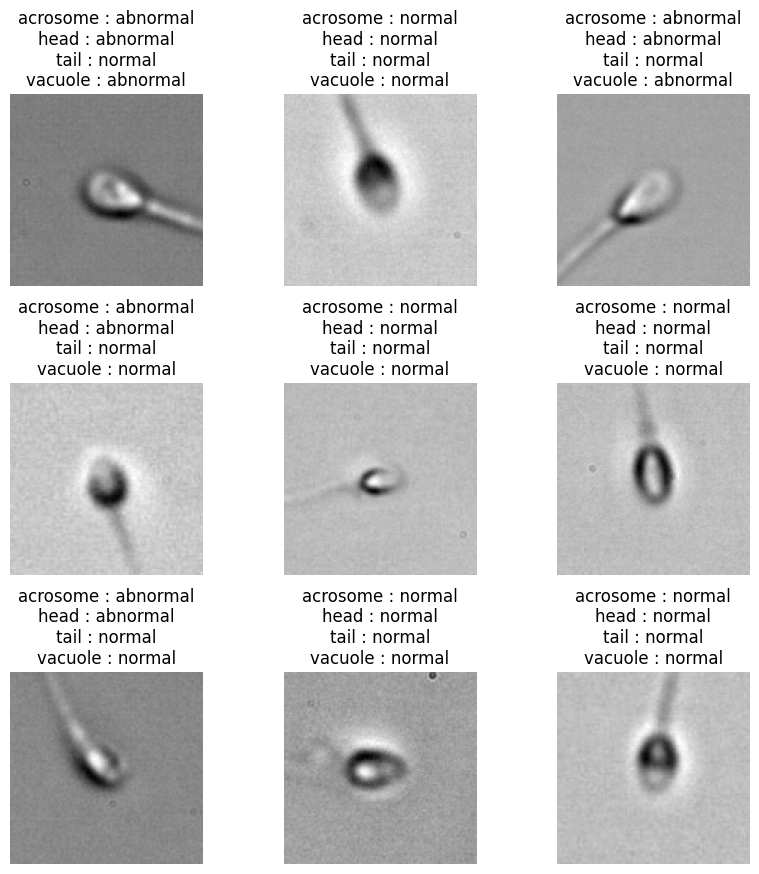

In [5]:
plt.figure(figsize=(10, 10))
state = ['normal', 'abnormal']
for i in range(9):
    img = x_128_train[i]
    acrosome = state[y_acrosome_train[i]]
    head = state[y_head_train[i]]
    tail = state[y_tail_train[i]]
    vacuole = state[y_vacuole_train[i]]
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(img, cmap='gray', )
    plt.title(f'acrosome : {acrosome}\nhead : {head}\ntail : {tail}\nvacuole : {vacuole}')
    plt.subplots_adjust(hspace=0.5)
    plt.axis('off')
plt.show()

### Imbalance problem solving with over sampling

##### acrosome

In [6]:
#extract normal and abnormal indexes
normal_index = np.where(y_acrosome_train == 0)[0]
abnormal_index = np.where(y_acrosome_train == 1)[0]

In [7]:
#extend the number of abnormal images by oversampling randomlly
abnormal_index = np.append(abnormal_index, random.choices(abnormal_index, k=len(normal_index)-len(abnormal_index)))
#concatenate normal and abnormal indexes
acrosome_index = np.concatenate([normal_index, abnormal_index])

In [8]:
#shuffle the whole indexes several times
for _ in range(10):
    np.random.shuffle(acrosome_index)

In [9]:
#construct the training dataset and labels for acrosome classification
x_acrosome_train = x_128_train[acrosome_index]
y_acrosome_train = y_acrosome_train[acrosome_index]

In [10]:
print(f'Shape of x_acrosome_train : {x_acrosome_train.shape}')
print(f'Shape of y_acrosome_train : {y_acrosome_train.shape}')

Shape of x_acrosome_train : (1398, 128, 128)
Shape of y_acrosome_train : (1398,)


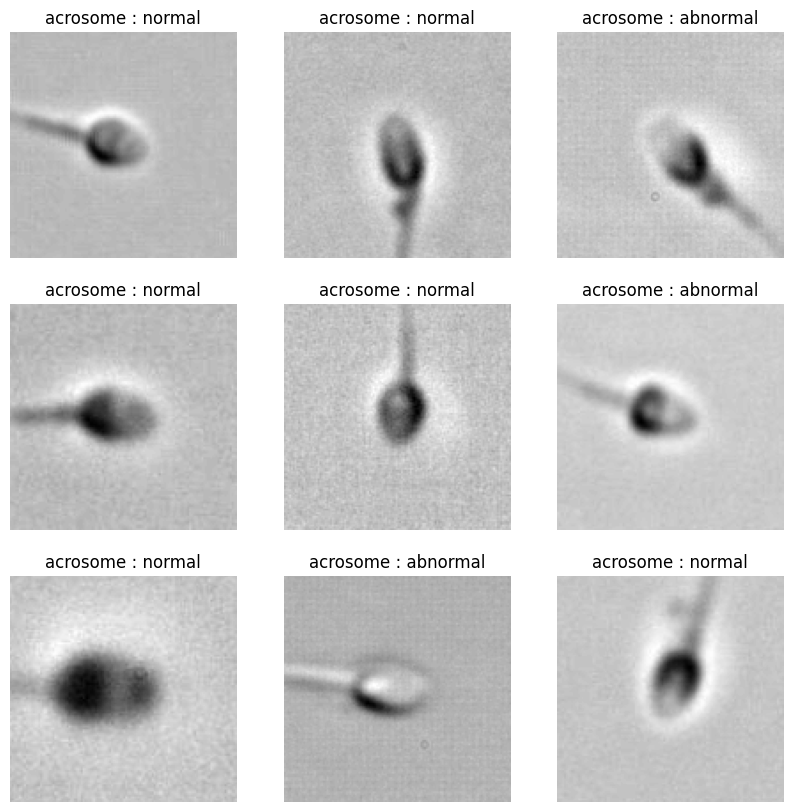

In [11]:
plt.figure(figsize=(10, 10))
state = ['normal', 'abnormal']
for i in range(9):
    img = x_acrosome_train[i]
    acrosome = state[y_acrosome_train[i]]
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f'acrosome : {acrosome}')
    plt.axis('off')
plt.show()

### Augmentation

In [12]:
x_acrosome_train_aug = []
for i, img in enumerate(x_acrosome_train):
    if i % 3 == 0 :
        img = cv2.flip(img, 0)
    if i % 4 == 0:
        img = rotate(img, random.randint(20, 90), mode='reflect', reshape=False)
    x_acrosome_train_aug.append(img)
x_acrosome_train_aug = np.array(x_acrosome_train_aug)

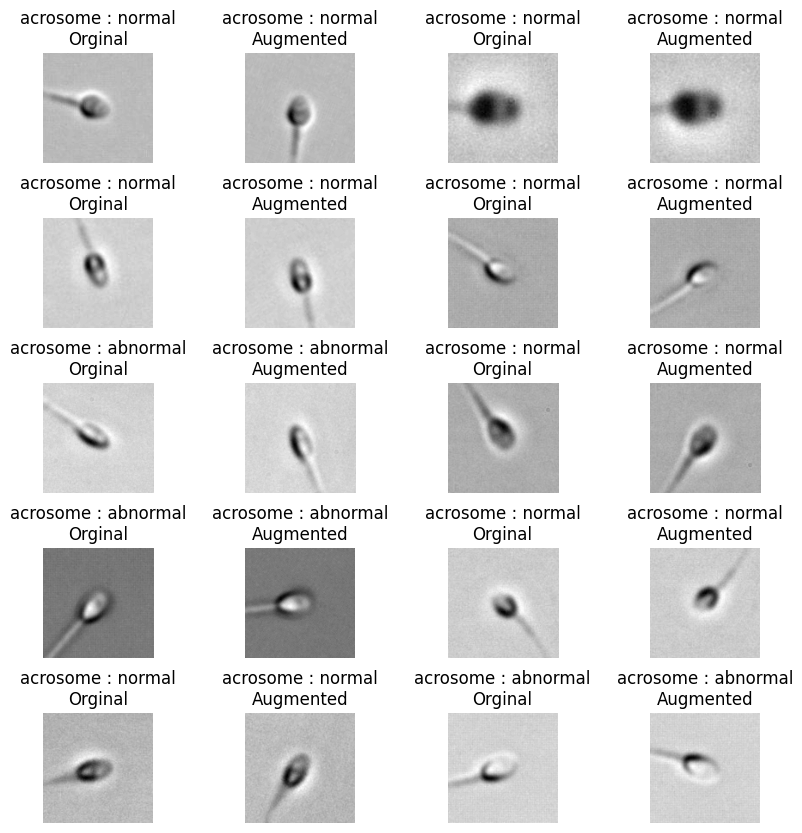

In [13]:
plt.figure(figsize=(10, 10))
state = ['normal', 'abnormal']
for i in range(0, 20, 2):
    img = x_acrosome_train[i*3]
    acrosome = state[y_acrosome_train[i*3]]
    ax = plt.subplot(5, 4, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f'acrosome : {acrosome}\nOrginal')
    plt.axis('off')
    
    img = x_acrosome_train_aug[i*3]
    acrosome = state[y_acrosome_train[i*3]]
    ax = plt.subplot(5, 4, i+2)
    plt.imshow(img, cmap='gray')
    plt.title(f'acrosome : {acrosome}\nAugmented')
    plt.axis('off')
    
    plt.subplots_adjust(hspace=0.5)
    
plt.show()

### Normalization

In [35]:
x_128_train = x_128_train / 255
x_acrosome_train_aug = x_acrosome_train_aug / 255
x_128_valid = x_128_valid / 255

### Model

In [36]:
model_2 = tf.keras.models.Sequential()

model_2.add(Conv2D(16, (5, 5), padding='same', input_shape=(128, 128, 1)))
model_2.add(Conv2D(16, (5, 5), padding='same', activation='selu'))
model_2.add(Conv2D(16, (5, 5), padding='same', activation='selu'))
model_2.add(Conv2D(16, (5, 5), padding='same', activation='selu'))
model_2.add(Conv2D(16, (5, 5), padding='same', activation='selu'))
model_2.add(Conv2D(16, (5, 5), padding='same', activation='selu'))
model_2.add(Conv2D(16, (5, 5), padding='same', activation='selu'))
model_2.add(Conv2D(16, (5, 5), padding='same', activation='selu'))

model_2.add(MaxPool2D((2, 2), 2))

model_2.add(Conv2D(32, (3, 3), padding='same', activation='selu'))
model_2.add(Conv2D(32, (3, 3), padding='same', activation='selu'))
model_2.add(Conv2D(32, (3, 3), padding='same', activation='selu'))
model_2.add(Conv2D(32, (3, 3), padding='same', activation='selu'))
model_2.add(Conv2D(32, (3, 3), padding='same', activation='selu'))
model_2.add(Conv2D(32, (3, 3), padding='same', activation='selu'))
model_2.add(Conv2D(32, (3, 3), padding='same', activation='selu'))
model_2.add(Conv2D(32, (3, 3), padding='same', activation='selu'))

model_2.add(MaxPool2D((2, 2), 2))

model_2.add(Conv2D(64, (3, 3), padding='same', activation='selu'))
model_2.add(Conv2D(64, (3, 3), padding='same', activation='selu'))
model_2.add(Conv2D(64, (3, 3), padding='same', activation='selu'))
model_2.add(Conv2D(64, (3, 3), padding='same', activation='selu'))
model_2.add(Conv2D(64, (3, 3), padding='same', activation='selu'))
model_2.add(Conv2D(64, (3, 3), padding='same', activation='selu'))
model_2.add(Conv2D(64, (3, 3), padding='same', activation='selu'))
model_2.add(Conv2D(64, (3, 3), padding='same', activation='selu'))

model_2.add(MaxPool2D((2, 2), 2))

model_2.add(Conv2D(64, (3, 3), padding='same', activation='selu'))
model_2.add(Conv2D(64, (3, 3), padding='same', activation='selu'))
model_2.add(Conv2D(64, (3, 3), padding='same', activation='selu'))
model_2.add(Conv2D(64, (3, 3), padding='same', activation='selu'))
model_2.add(Conv2D(64, (3, 3), padding='same', activation='selu'))
model_2.add(Conv2D(64, (3, 3), padding='same', activation='selu'))
model_2.add(Conv2D(64, (3, 3), padding='same', activation='selu'))
model_2.add(Conv2D(64, (3, 3), padding='same', activation='selu'))

model_2.add(AvgPool2D((2, 2), 2))

model_2.add(Flatten())
model_2.add(Dense(1024, activation='selu'))
model_2.add(Dense(1024, activation='selu'))
model_2.add(Dense(1, activation='sigmoid'))

In [37]:
model_2.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_209 (Conv2D)         (None, 128, 128, 16)      416       
                                                                 
 conv2d_210 (Conv2D)         (None, 128, 128, 16)      6416      
                                                                 
 conv2d_211 (Conv2D)         (None, 128, 128, 16)      6416      
                                                                 
 conv2d_212 (Conv2D)         (None, 128, 128, 16)      6416      
                                                                 
 conv2d_213 (Conv2D)         (None, 128, 128, 16)      6416      
                                                                 
 conv2d_214 (Conv2D)         (None, 128, 128, 16)      6416      
                                                                 
 conv2d_215 (Conv2D)         (None, 128, 128, 16)     

### Training

In [38]:
model_2.compile(optimizer='adam', loss='BinaryCrossentropy', metrics=['accuracy', 'Precision', 'Recall'])

In [40]:
model_2.fit(x_acrosome_train_aug, y_acrosome_train, batch_size=64, epochs=1, validation_data=(x_128_valid, y_acrosome_valid))

22/22 [==============================] - 551s 25s/step - loss: 25.8483 - accuracy: 0.5072 - precision: 0.5078 - recall: 0.4649 - val_loss: 4.1577 - val_accuracy: 0.7250 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
